<a href="https://colab.research.google.com/github/lakshiyasrp/projects/blob/main/Flower_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FLOWERS CLUSTERING USING K-MEANS**

**ABOUT DATASET :**

*The dataset consists of 5 different flower classes. Lilly, Lotus, Sunflower, Orchid and Tulip. Each flower class has 1000 images*

**INSTALL** **LIBRARIES**

In [ ]:
import kagglehub
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #data visualization library
from sklearn.cluster import KMeans
import albumentations as A

**DOWNLOAD DATASET FROM KAGGLEHUB**

In [ ]:
path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")
print("Dataset downloaded to:", path)

# Check the actual dataset structure
print("Files in dataset:", os.listdir(path))

dataset_path = None
for root, dirs, files in os.walk(path):
    if len(files) > 10:  # Assuming dataset contains many images
        dataset_path = root
        break

if dataset_path is None:
    raise FileNotFoundError("Could not find a valid image folder. Check the dataset structure.")

print("Dataset path set to:", dataset_path)

100%|██████████| 242M/242M [00:02<00:00, 112MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1
Files in dataset: ['flower_images']
Dataset path set to: /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1/flower_images/Sunflower


**LOAD IMAGES**

In [ ]:
def load_images_from_folder(folder, max_images=100):
    images = []
    for filename in os.listdir(folder)[:max_images]:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

# Preprocess images
def preprocess_images(images, size=(128, 128)):
    preprocessed = []
    for img in images:
        img_resized = cv2.resize(img, size)
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_gray = np.uint8(img_gray * 255)  # Convert to 8-bit before augmentation
        preprocessed.append(img_gray)
    return np.array(preprocessed)

**IMAGE SEGMENTATION**

In [ ]:
# Image segmentation using thresholding
def segment_images(images):
    segmented = []
    for img in images:
        _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY) #by comparing the brightness of each pixel to a threshold value
        segmented.append(binary)
    return np.array(segmented)


**IMAGE AUGMENTATION**

In [ ]:
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5)
])

def augment_images(images):
    augmented_images = []
    for img in images:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) #OpenCV reads images in BGR format, so they are converted to RGB format for proper visualization
        augmented = augmentation_pipeline(image=img_rgb)
        aug_gray = cv2.cvtColor(augmented['image'], cv2.COLOR_RGB2GRAY)
        augmented_images.append(aug_gray)
    return np.array(augmented_images)

# Load and preprocess images
all_images = load_images_from_folder(dataset_path, max_images=200)
grayscale_images = preprocess_images(all_images)
segmented_images = segment_images(grayscale_images)
augmented_images = augment_images(grayscale_images)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


**VISUALIZING IMAGES**

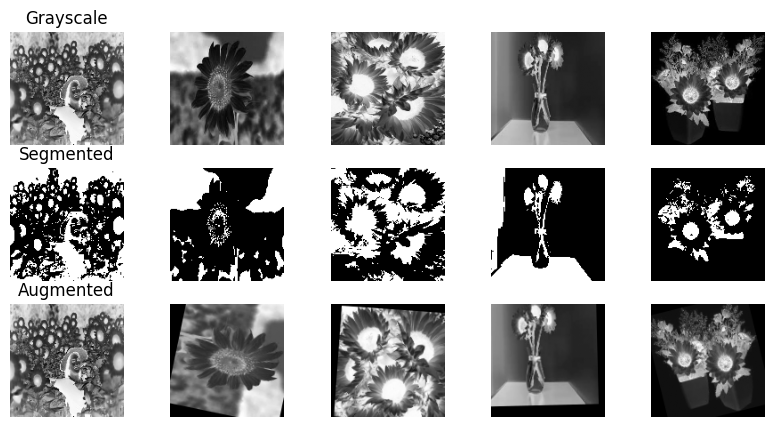

In [ ]:
# Visualizing grayscale, segmented, and augmented images
def visualize_images(original, segmented, augmented, num=5):
    plt.figure(figsize=(10, 5))
    for i in range(num):
        plt.subplot(3, num, i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Grayscale") #reduce 3 color channel into a single channel

        plt.subplot(3, num, i + 1 + num)
        plt.imshow(segmented[i], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Segmented")

        plt.subplot(3, num, i + 1 + 2*num)
        plt.imshow(augmented[i], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Augmented")

    plt.show()

visualize_images(grayscale_images, segmented_images, augmented_images)

# Flatten images for clustering
num_samples, height, width = augmented_images.shape
flattened_images = augmented_images.reshape(num_samples, height * width) #convert into 1D array(K-Means works on tabular data)


**ELBOW METHOD TO DETERMINE OPTIMAL K**

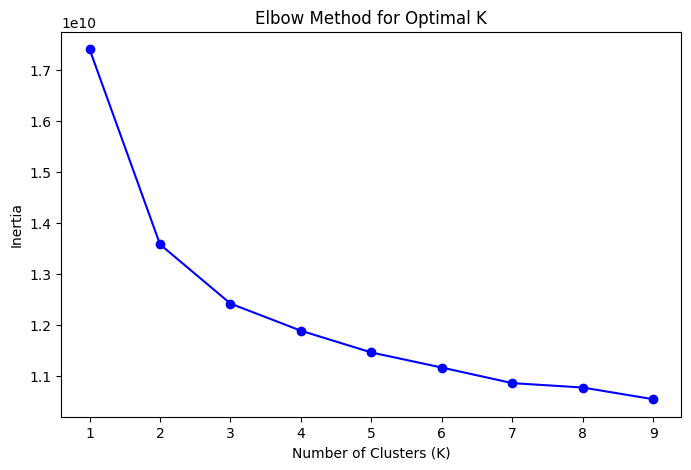

In [ ]:
def elbow_method(features):
    distortions = []
    K_range = range(1, 10)
    for i in K_range:
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(features)
        distortions.append(kmeans.inertia_)
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, distortions, 'bo-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia') #measure of how well clusters are formed in K-Means clustering
    plt.title('Elbow Method for Optimal K')
    plt.show()

elbow_method(flattened_images)

**K-MEANS CLUSTERING ON RGB PIXEL**

In [ ]:
k = 3  # Number of clusters
height, width, _ = all_images[0].shape
flattened_rgb_pixels = all_images[0].reshape(-1, 3)  # Reshape to (num_pixels, 3) for RGB clustering

kmeans_rgb = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_rgb_labels = kmeans_rgb.fit_predict(flattened_rgb_pixels) #RGB pixels are used in clustering because they represent the color information of an image, allowing us to group similar colors together

# Reshape labels for segmentation output
segmented_rgb_image = kmeans_rgb_labels.reshape(height, width)


**CLUSTER SCATTER PLOT**

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


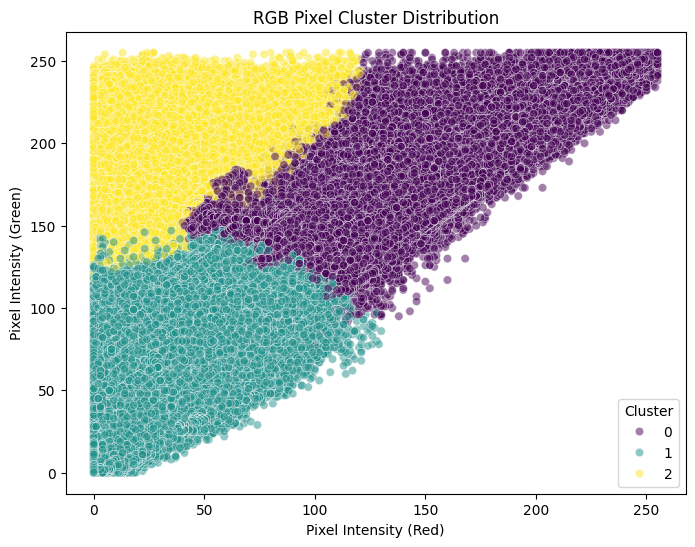

In [ ]:
# Cluster Scatter Plot for RGB Pixels
def cluster_scatter_plot(pixels, labels):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=pixels[:, 0], y=pixels[:, 1], hue=labels, palette='viridis', alpha=0.5)
    plt.xlabel('Pixel Intensity (Red)')
    plt.ylabel('Pixel Intensity (Green)')
    plt.title('RGB Pixel Cluster Distribution')
    plt.legend(title="Cluster")
    plt.show()

cluster_scatter_plot(flattened_rgb_pixels, kmeans_rgb_labels)

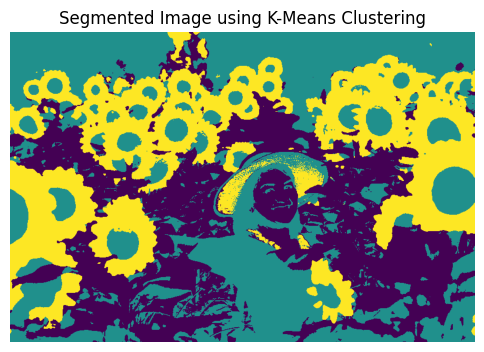

In [ ]:
# Reconstruct clustered image
def reconstruct_clustered_image(labels, shape): #the result of applying K-Means clustering to the RGB pixel values of the first image in dataset (all_images[0]).
    plt.figure(figsize=(6, 6))
    plt.imshow(labels, cmap='viridis') #color map used in Matplotlib and Seaborn for visualizing data. It provides a smooth, perceptually uniform gradient from dark purple to yellow-green.
    plt.axis('off')
    plt.title("Segmented Image using K-Means Clustering")
    plt.show()

# Display clustered RGB image
reconstruct_clustered_image(segmented_rgb_image, (height, width))


**EXPLANATION OF THE FLOWERS CLUSTERING**

**Step 1: Import Necessary Libraries**

Various Python libraries are used:

kagglehub → To download datasets from Kaggle.

OpenCV (cv2) → For image reading, processing, and color conversion.

NumPy → To handle numerical computations.

Matplotlib & Seaborn → For visualization of images and clustering results.

Scikit-Learn (KMeans) → To perform clustering on image pixels.

Albumentations → For image augmentation techniques.

**Step 2: Download and Load the Dataset**

The dataset is downloaded from Kaggle.
The folder structure is inspected to locate the image files.
Images are loaded from the dataset directory using OpenCV.
OpenCV reads images in BGR format, so they are converted to RGB format for proper visualization.


**Step 3: Preprocess the Images**

Images are resized to a fixed size (e.g., 128×128 pixels) to standardize input data.
Resizing ensures that all images have the same dimensions, making computations easier.


**Step 4: Apply Image Augmentation**

Augmentation techniques introduce variations in images to improve robustness:

Horizontal Flip → Flips the image horizontally.

Random Rotation → Rotates the image by a random angle.

Brightness and Contrast Adjustment → Modifies brightness and contrast.

Shift, Scale, Rotate → Applies small shifts, rescaling, and rotations.

These techniques help in handling variations in real-world datasets.


**Step 5: Convert Images to Grayscale**

Color images are converted to grayscale.
Grayscale images simplify processing by reducing 3 color channels (RGB) into a single channel.
This is useful for tasks like segmentation and clustering.


**Step 6: Visualizing Images**

Three sets of images are displayed:

Original grayscale images,
Segmented images (dummy placeholder for now),
Augmented images (after applying transformations).


**Step 7: Flatten the Images**

Each image is converted into a 1D array.

This is necessary because clustering algorithms like K-Means work on tabular data (features in rows, dimensions in columns).



**Step 8: Determine the Optimal Number of Clusters using the Elbow Method**

K-Means clustering requires choosing the right number of clusters (K).

The Elbow Method is used to determine the optimal K:

It plots the inertia (sum of squared distances within clusters) against different values of K.
The "elbow point" (where inertia stops decreasing significantly) suggests the best K.
This helps to avoid choosing too many or too few clusters.


**Step 9: Apply K-Means Clustering on RGB Pixels**

Clustering is performed on pixel values (R, G, B components).
Each pixel (R, G, B triplet) is treated as a data point in 3D space.
K-Means groups similar pixels into K clusters.
Each cluster represents a dominant color in the image.

Why Use RGB Pixels in Clustering?

1️⃣ Color-Based Segmentation 🟥🟩🟦

Clustering groups similar color pixels together.
Helps in object detection and background removal.

2️⃣ Feature Reduction 🔽

Instead of analyzing the whole image, we only consider color information.
Helps simplify image processing tasks.

3️⃣ Unsupervised Learning for Image Processing 🤖

No need for labeled data; clustering automatically groups similar pixels.

4️⃣ Image Compression 📉

Clustering reduces colors → Creates compressed versions of images.



**Step 10: Reshape the Cluster Labels into an Image**

The clustered pixels (labels) are reshaped back into the original image dimensions.
This results in a segmented image, where each cluster is represented by a different color.

**Step 11: Visualize the Clustering Results**

Scatter Plot of RGB Clusters:

Each pixel is plotted in R-G space, colored based on its assigned cluster.
This shows how the algorithm groups similar colors.

Segmented Image:

The clustered image is displayed using different colors for different clusters.
This helps in image segmentation, where regions with similar colors are grouped together.


**Conclusion**

This approach helps in image segmentation and clustering by grouping similar pixel colors.

It can be used in object detection, background removal, and feature extraction.
The Elbow Method ensures optimal cluster selection for better segmentation.